<a href="https://colab.research.google.com/github/KenzaxTazi/Agri-Risk/blob/master/RFECV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, sys
path = '/content/drive/My Drive/GTC'
os.chdir(path)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
%matplotlib inline

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

## Import datasets

In [4]:
seasonal_df = pd.read_csv("WORLD_['maiz']_['CDD', 'CWD', 'CFD', 'CSDI', 'WSDI', 'WW']_2010_2005_climate_zones_onehot.csv")
seasonal_features_df = seasonal_df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'],
                                        axis=1)
seasonal_features_df

,iso3_2005,x,y,maiz_a_2005,maiz_a_2010,delta_maiz,maiz_percent_change,CDD-Q1_2005,CDD-Q1_2010,CDD-Q2_2005,CDD-Q2_2010,CDD-Q3_2005,CDD-Q3_2010,CDD-Q4_2005,CDD-Q4_2010,CWD-Q1_2005,CWD-Q1_2010,CWD-Q2_2005,CWD-Q2_2010,CWD-Q3_2005,CWD-Q3_2010,CWD-Q4_2005,CWD-Q4_2010,CFD-Q1_2005,CFD-Q1_2010,CFD-Q2_2005,CFD-Q2_2010,CFD-Q3_2005,CFD-Q3_2010,CFD-Q4_2005,CFD-Q4_2010,CSDI-Q1_2005,CSDI-Q1_2010,CSDI-Q2_2005,CSDI-Q2_2010,CSDI-Q3_2005,CSDI-Q3_2010,CSDI-Q4_2005,CSDI-Q4_2010,WSDI-Q1_2005,WSDI-Q1_2010,WSDI-Q2_2005,WSDI-Q2_2010,WSDI-Q3_2005,WSDI-Q3_2010,WSDI-Q4_2005,WSDI-Q4_2010,WW-Q1_2005,WW-Q1_2010,WW-Q2_2005,WW-Q2_2010,WW-Q3_2005,WW-Q3_2010,WW-Q4_2005,WW-Q4_2010,climate_zone,soil_type,Inland water bodies,Subtropics - summer rainfall,Subtropics - winter rainfall,Temperature - continental,Temperature - oceanic,Temperature - subcontinental,Tropics
0,CIV,-3.208,5.208,2292.2,2867.5,575.3,0.250982,24.0,31.0,3.0,2.0,6.0,6.0,2.0,1.0,10.0,21.0,30.0,26.0,25.0,27.0,65.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0,24.0,1.0,11.0,13.0,16.0,Inland water bodies,4.0,1,0,0,0,0,0,0
1,USA,-76.042,35.958,6665.7,6052.0,-613.7,-0.092068,18.0,8.0,7.0,11.0,11.0,6.0,12.0,11.0,5.0,4.0,5.0,5.0,11.0,6.0,9.0,6.0,9.0,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,3.0,3.0,4.0,Inland water bodies,2.0,1,0,0,0,0,0,0
2,USA,-76.292,35.958,7071.2,6420.1,-651.1,-0.092078,18.0,8.0,7.0,11.0,11.0,6.0,12.0,11.0,5.0,4.0,5.0,5.0,11.0,6.0,9.0,6.0,9.0,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,3.0,3.0,4.0,Inland water bodies,2.0,1,0,0,0,0,0,0
3,USA,-76.458,35.958,7471.4,6671.0,-800.4,-0.107129,18.0,8.0,7.0,11.0,11.0,6.0,12.0,11.0,5.0,4.0,5.0,5.0,11.0,6.0,9.0,6.0,9.0,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,3.0,3.0,4.0,Inland water bodies,2.0,1,0,0,0,0,0,0
4,CHN,116.042,29.792,8656.9,7956.7,-700.2,-0.080883,17.0,11.0,11.0,8.0,8.0,6.0,22.0,21.0,6.0,4.0,7.0,7.0,10.0,14.0,8.0,5.0,9.0,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0,6.0,0.0,0.0,4.0,3.0,4.0,0.0,0.0,5.0,0.0,Inland water bodies,1.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307857,RUS,61.375,54.625,2170.3,2179.6,9.3,0.004285,30.0,17.0,11.0,22.0,11.0,11.0,29.0,35.0,4.0,4.0,2.0,3.0,7.0,5.0,4.0,2.0,90.0,90.0,37.0,48.0,0.0,0.0,22.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,Temperature - continental,18.0,0,0,0,1,0,0,0
307858,RUS,61.458,54.625,2062.6,2071.4,8.8,0.004266,30.0,17.0,11.0,22.0,11.0,11.0,29.0,35.0,4.0,4.0,2.0,3.0,7.0,5.0,4.0,2.0,90.0,90.0,37.0,48.0,0.0,0.0,22.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,Temperature - continental,18.0,0,0,0,1,0,0,0
307859,CHN,123.542,43.792,5086.2,4958.5,-127.7,-0.025107,39.0,29.0,38.0,10.0,11.0,13.0,25.0,26.0,2.0,1.0,2.0,4.0,12.0,8.0,4.0,3.0,90.0,90.0,19.0,29.0,0.0,0.0,26.0,11.0,6.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,3.0,0.0,Temperature - continental,33.0,0,0,0,1,0,0,0
307860,CHN,123.042,53.292,2819.2,3918.1,1098.9,0.389791,27.0,27.0,49.0,29.0,8.0,9.0,14.0,16.0,2.0,3.0,2.0,5.0,7.0,4.0,3.0,4.0,90.0,90.0,65.0,61.0,1.0,1.0,61.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,Boreal - continental,40.0,0,0,0,0,0,0,0


# Cross-validated RFE

In [0]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection
from sklearn.model_selection import KFold
import time

In [0]:
pipe = Pipeline(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500,n_jobs=-1))
    ]
)

In [0]:
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

## RFECV with all features

In [0]:
seasonal_features_df.dropna(inplace=True)
X=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone'], axis=1)[0:1000]
y = seasonal_features_df['maiz_a_2010'][0:1000]

In [0]:
feature_names = seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone'], axis=1).columns

In [36]:
start = time.time()
pipe = PipelineRFE(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1))
    ]
)

_ = KFold(random_state=42, shuffle=True)

feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

training time: 2502.3869705200195s
number of features: 3


In [37]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([927.3954993 , 178.40897842, 171.3153828 , 199.484713  ,
       219.69910984, 219.36942069, 228.13409   , 233.87591546,
       242.60836028, 246.24510156, 250.77720494, 255.32063602,
       256.84328934, 260.29052387, 260.29292021, 263.04508926,
       262.38933413, 263.776399  , 264.26851742, 266.38060068,
       270.0829583 , 269.86706671, 270.87999527, 273.56225211,
       272.24585656, 274.74509506, 274.60749507, 276.00397354,
       275.29385233, 276.17314685, 276.41078926, 278.95898463,
       278.30918252, 277.73460984, 278.04126714, 277.95808795,
       277.26982675, 278.9287252 , 279.84119049, 279.67149379,
       279.02159634, 279.73583899, 279.73508463, 279.67086539,
       278.661138  , 279.6924242 , 279.70000751, 277.82533205,
       278.76544123, 278.84648159, 281.27486947, 280.40287956,
       277.83395868, 280.37336771, 281.35110069, 280.71770764,
       281.1472887 , 280.8451988 , 279.28489099, 280.61069665,
       280.59031294])

In [44]:
selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['maiz_a_2005', 'delta_maiz', 'maiz_percent_change']

## RFECV, removing yield information

In [0]:
seasonal_features_df.dropna(inplace=True)
X=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone', 'maiz_a_2005', 'delta_maiz', 'maiz_percent_change'], axis=1)[0:1000]
y = seasonal_features_df['maiz_a_2010'][0:1000]

In [47]:
start = time.time()
pipe = PipelineRFE(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1))
    ]
)

_ = KFold(random_state=42, shuffle=True)

feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

training time: 2298.72750043869s
number of features: 2


In [49]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([2370.72799307, 1668.04342313, 1673.45354373, 1745.89262393,
       1758.70258827, 1787.64891709, 1758.10546898, 1747.51675512,
       1723.70095387, 1728.86310374, 1725.30115112, 1732.09027203,
       1739.60427514, 1737.51920768, 1739.91369244, 1746.40637989,
       1750.46719657, 1751.54961723, 1746.14889407, 1748.44155994,
       1751.14844323, 1756.21733428, 1751.11096247, 1756.99685507,
       1753.20828456, 1750.0329302 , 1754.94702434, 1757.36473586,
       1755.88424432, 1754.29403893, 1755.21199475, 1749.53758421,
       1754.28468176, 1749.4601014 , 1750.64189976, 1741.82240727,
       1740.01682112, 1748.71144411, 1743.93908239, 1738.42858129,
       1734.18163703, 1740.54234784, 1737.91705828, 1740.83263779,
       1739.7752306 , 1738.97655365, 1739.39707024, 1740.30442411,
       1740.46485824, 1739.32527225, 1741.01619359, 1741.05905609,
       1740.71611279, 1740.06979973, 1739.07576649, 1736.7394806 ,
       1738.52090493, 1740.85135807])

In [54]:
feature_names=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone', 'maiz_a_2005', 'delta_maiz', 'maiz_percent_change'], axis=1).columns

selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['x', 'y']

## RFECV, removing x, y coordinatees

In [0]:
# try also dropping x and y
seasonal_features_df.dropna(inplace=True)
X=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone', 'maiz_a_2005', 'delta_maiz', 'maiz_percent_change','x','y'], axis=1)[0:1000]
y = seasonal_features_df['maiz_a_2010'][0:1000]

In [56]:
start = time.time()
pipe = PipelineRFE(
    [
        ('std_scaler', preprocessing.StandardScaler()),
        ("RF", RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1))
    ]
)

_ = KFold(random_state=42, shuffle=True)

feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
feature_selector_cv.fit(X, y)
stop=time.time()
print(f"training time: {stop-start}s")
print(f"number of features: {feature_selector_cv.n_features_}")

training time: 1902.294221162796s
number of features: 51


In [57]:
cv_grid_rmse = np.sqrt(-feature_selector_cv.grid_scores_)
cv_grid_rmse

array([2252.57783273, 2269.99347577, 2145.1441323 , 2087.60780325,
       2009.98117958, 1973.05451787, 1933.01814516, 1901.19163399,
       1870.21886283, 1862.09409061, 1841.45300395, 1824.93159154,
       1833.98486045, 1842.09169656, 1844.04876613, 1838.49400026,
       1843.12892735, 1848.67896682, 1843.81418175, 1850.51372166,
       1846.96998624, 1837.30349677, 1839.7618289 , 1830.14425087,
       1827.45490273, 1826.79488478, 1827.6977965 , 1835.5070222 ,
       1838.17837714, 1839.97130784, 1831.85796611, 1837.09031866,
       1834.71352124, 1835.91345903, 1835.46059723, 1826.68918208,
       1821.68398801, 1829.38498416, 1826.17216871, 1825.46052684,
       1822.9244505 , 1821.21585876, 1822.6403314 , 1827.27107531,
       1823.79948741, 1821.30627648, 1824.21391339, 1823.50088292,
       1823.15870864, 1821.16221691, 1818.96876219, 1820.29895493,
       1822.37833235, 1822.00399059, 1822.66445723, 1823.14948045])

In [58]:
feature_names=seasonal_features_df.drop(['maiz_a_2010'], axis=1).drop(['iso3_2005','climate_zone', 'maiz_a_2005', 'delta_maiz', 'maiz_percent_change', 'x', 'y'], axis=1).columns

selected_features = feature_names[feature_selector_cv.support_].tolist()
selected_features

['CDD-Q1_2005',
 'CDD-Q1_2010',
 'CDD-Q2_2005',
 'CDD-Q2_2010',
 'CDD-Q3_2005',
 'CDD-Q3_2010',
 'CDD-Q4_2005',
 'CDD-Q4_2010',
 'CWD-Q1_2005',
 'CWD-Q1_2010',
 'CWD-Q2_2005',
 'CWD-Q2_2010',
 'CWD-Q3_2005',
 'CWD-Q3_2010',
 'CWD-Q4_2005',
 'CWD-Q4_2010',
 'CFD-Q1_2005',
 'CFD-Q1_2010',
 'CFD-Q2_2005',
 'CFD-Q2_2010',
 'CFD-Q3_2005',
 'CFD-Q3_2010',
 'CFD-Q4_2005',
 'CFD-Q4_2010',
 'CSDI-Q1_2005',
 'CSDI-Q1_2010',
 'CSDI-Q2_2005',
 'CSDI-Q2_2010',
 'CSDI-Q3_2005',
 'CSDI-Q3_2010',
 'CSDI-Q4_2005',
 'CSDI-Q4_2010',
 'WSDI-Q1_2005',
 'WSDI-Q1_2010',
 'WSDI-Q2_2005',
 'WSDI-Q2_2010',
 'WSDI-Q3_2005',
 'WSDI-Q3_2010',
 'WSDI-Q4_2005',
 'WSDI-Q4_2010',
 'WW-Q1_2005',
 'WW-Q1_2010',
 'WW-Q2_2005',
 'WW-Q2_2010',
 'WW-Q3_2005',
 'WW-Q3_2010',
 'WW-Q4_2005',
 'WW-Q4_2010',
 'soil_type',
 'Inland water bodies',
 'Subtropics - summer rainfall']

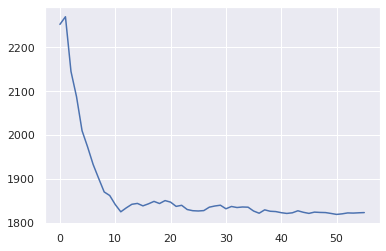

In [60]:
plt.plot(cv_grid_rmse)